<a href="https://colab.research.google.com/github/alanbseo/LCAworkshop/blob/master/LCA_1_BW25_browser_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook is imported from the https://live.brightway.dev/lab/index.html

References: https://learn.brightway.dev/en/latest/content/notebooks/BW25_for_beginners.html
https://live.brightway.dev/lab/index.html
https://github.com/maximikos/Brightway2_Intro/blob/master/BW2_tutorial.ipynb
Please see the overview at https://wiki.ubc.ca/Documentation:Brightway_Tutorials
API documentation https://docs.brightway.dev/en/latest/api/index.html

# Imports

In [1]:
# install the BW package
!pip install brightway25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 14.2 MB/s eta 0:00:00
  Created wheel for brightway25: filename=brightway25-1.0.6-py3-none-any.whl size=3453 sha256=9a6aba339b066d8c3086463e4361564ba19037a6deb78a2

In [2]:
# Import BW25 packages. You'll notice the packages are imported individually, unlike a one-and-done import with BW2.
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

# Library for storing numeric data for use in matrix-based calculations. Designed for use with the Brightway life cycle assessment framework.
import bw_processing as bwp

import matrix_utils as mu
import numpy as np
import pandas as pd
import seaborn as sb


Brightway25 is the umbrella package, as well as documentation. When installing this package, it will pull as dependencies the following packages:
Brightway2-data handles storing and searching all data sources (databases, LCIA methods, etc.).
Brightway2-calc does LCA calculations.
Brightway2-io tools for the import, export, and management of inventory databases and impact assessment methods. LCA calculations.
Brightway2-analyzer analyzes input data like databases and methods, as well as the result of LCA calculations.
Brightway2-parameters Library for storing, validating, and calculating with parameters.


Before we dive into it, let's think about what we need to actually build a matrix. What specific data would you need? What don't you need?

## Exercise

Please think about the minimal set of information you would need to build a *sparse matrix* using [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (sparse matrices store only non-zero values). Then, create this information as Numpy arrays and actually build a sparse matrix.

Here is the matrix you should build:

$$\begin{bmatrix} 0 & 1 \\ 2 & 3 \end{bmatrix}$$

## Hint

You will need three Numpy arrays: one for the data, one for the row indices, and one for the column indices.

## Solution

In [3]:
from scipy import sparse

data = np.array([1, 2, 3])
rows = np.array([0, 1, 1])
cols = np.array([1, 0, 1])

matrix = sparse.coo_matrix((data, (rows, cols)), (2, 2))
matrix.toarray()

array([[0, 1],
       [2, 3]])

## `bw_processing`

We can run into difficulties when we want to store this data. The library `bw_processing` helps us create data packages, which can store this matrix-building data on variety of file systems. You can read the [`bw_processing` README](github.com/brightway-lca/bw_processing) for more information, and can see the [PyFilesystem2 Docs](https://docs.pyfilesystem.org/en/latest/) for more on the filesystems that can be used.

Let's define this same matrix in `bw_processing`.

Matrices by definition are two-dimensional, so we know that to build matrices we will always need to specify the row and column indices of the data. We combine these two arrays into a single Numpy [structured array](https://numpy.org/doc/stable/user/basics.rec.html), which uses the labels `row` and `col`.

In [4]:
import bw_processing as bwp
import numpy as np

indices_array = np.array([(0, 1), (1, 0), (1, 1)], dtype=bwp.INDICES_DTYPE)
indices_array

array([(0, 1), (1, 0), (1, 1)], dtype=[('row', '<i4'), ('col', '<i4')])

In [5]:
indices_array['row']

array([0, 1, 1], dtype=int32)

In [6]:
bwp.INDICES_DTYPE

[('row', numpy.int32), ('col', numpy.int32)]

The data array is the same as before:

In [7]:
data_array = np.array([1, 2, 3])
data_array

array([1, 2, 3])

This is all we need to create a data package:

In [8]:
dp = bwp.create_datapackage()

# Data objects can be vectors or arrays. Vectors will always produce the same matrix, while arrays have multiple possible values for each element of the matrix.

# Persistent data is fixed, and can be completely loaded into memory and used directly or written to disk.
# Dynamic data is only resolved as the data is used, during matrix construction and iteration.
# Dynamic data is provided by interfaces - Python code that either generates the data, or wraps data coming from other software.

dp.add_persistent_vector(
    matrix="some name",
    data_array=data_array,
    name="some name",
    indices_array=indices_array,
)

For such simple matrices, we can also use a shortcut:

In [9]:
bwp.simple_graph({
    "some name": [
        (0, 1, 1),
        (1, 1, 2),
        (1, 1, 3),
    ]
})

But before this gets too abstract, let's do the same for our example system:

<img src='https://github.com/brightway-lca/from-the-ground-up/blob/main/images/simple-graph.png?raw=true' width='400'>

In our technosphere matrix, we will have three production exchanges (each of amount 1), and two consumption exchanges. Our biosphere matrix will only have one number, the emission of $CO_{2}$ from carbon fibre production.

Our matrices should look like this:

## Technosphere matrix

Dimensions are products (rows) by activities (columns).

$$
\left[\begin{array}{ccc}
1 & 0 & 0\\
-237 & 1 & 0\\
0 & -2.5 & 1\\
\end{array}\right]
$$

## Biosphere matrix

Dimensions are flows (rows) by activities (columns).

$$
\left[\begin{array}{ccc}
0 & 26.6 & 0\\
\end{array}\right]
$$

## Characterization matrix

Dimensions are flows (rows) by flows (columns).

$$
\left[\begin{array}{c}
1\\
\end{array}\right]
$$

In [ ]:
natural_gas = 101
carbon_fibre = 102
bike = 103
co2 = 201

# A first LCA calculation

To use datapackages, we need to know four thing for each point: the row and column ids, the data value, and the sign. We only need to store the non-zero points. Here is an example for the technosphere matrix:

In [ ]:
# LCI data
# https://github.com/brightway-lca/from-the-ground-up/blob/main/lci-bike.xlsx

# Technosphere
t_data = np.array([
    1,   # production of natural gas
    1,   # production of carbon fibre
    1,   # production of bike
    237, # input of natural gas
    2.5, # input of carbon fibre
])

# We need integer indices for each concept. The numbers themselves are arbitrary,
# the point is that we will use them consistently in the datapackages, and maintain a mapping from our concepts to these numbers.

t_indices = np.array([
    (101, 101), # production of natural gas
    (102, 102), # production of carbon fibre
    (103, 103), # production of bike
    (101, 102), # input of natural gas
    (102, 103), # input of carbon fibre
    ],
    dtype=bwp.INDICES_DTYPE
)
t_flip = np.array([False, False, False, True, True]) # Numerical sign of the inputs needs to be flipped negative

And similarly for the other matrices (no need to flip signs, so we skip that part):

In [ ]:
b_data = np.array([26.6])
b_indices = np.array([
    (201, 102), # emission of CO2
    ],
    dtype=bwp.INDICES_DTYPE
)

In [ ]:
c_data = np.array([1])
c_indices = np.array([
    (201, 201), # CF of CO2
    ],
    dtype=bwp.INDICES_DTYPE
)

We can now create our datapackage, and add the data for all three matrices to it:

In [ ]:
# The main interface for using this library is the Datapackage class. You should use the utility functions create_datapackage and load_datapackage.
# A datapackage is a set of file objects (either in-memory or on disk) that includes a metadata file object, and one or more data resource files objects.
# The metadata file object includes both generic metadata (i.e. when it was created, the data license) and metadata specific to each data resource (how it can be used in calculations, its relationship to other data resources).

dp_static = bwp.create_datapackage()

In [ ]:
dp_static.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
)
dp_static.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
)
dp_static.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

This is already enough to calculate an LCA score:

In [ ]:
# Base class for single and multi LCA classes
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static],
)

# The LC inventory. Calculate a life cycle inventory.
lca.lci()
# 1) Load LCI data, and construct the technosphere and biosphere matrices.
# 2) Build the demand array
# 3) Solve the linear system to get the supply array and life cycle inventory.

lca.lcia() # Calculate the life cycle impact assessment.
# 1) Load and construct the characterization matrix
# 2) Multiply the characterization matrix by the life cycle inventory

lca.score # The LCIA score as a float.


66.5

## Exercise

Do the same for your steel bike. Make sure you get the same LCIA results as before.

In [11]:
# Steel Bike LCIA

# In our technosphere matrix, we will have four production exchanges (each of amount 1),
# and three consumption exchanges.
# Our biosphere matrix will only have one number, the emission of Iron ore from Iron mining.


# activity node
coal = 100
iron_ore = 201
iron_mining = 101
steel = 102
steelbike = 103

# Technosphere
sb_t_data = np.array([
    1,   # production of iron mining
    1,   # production of coal
    1,   # production of steel
    1,   # production of steel bike
    1.1, # input of iron mining
    0.2, # input of coal
    8,   # input of steel
])

# We need integer indices for each concept. The numbers themselves are arbitrary,
# the point is that we will use them consistently in the datapackages, and maintain a mapping from our concepts to these numbers.

sb_t_indices = np.array([
    (101, 101), # production of iron mining
    (100, 100), # production of coal
    (102, 102), # production of steel
    (103, 103), # production of steel bike
    (101, 102), # input of iron mining
    (100, 102), # input of coal
    (102, 103), # input of steel
    ],
    dtype=bwp.INDICES_DTYPE
)
sb_t_flip = np.array([False, False, False, False, True, True, True]) # Numerical sign of the inputs needs to be flipped negative

# Biosphere
sb_b_data = np.array([1.25])
sb_b_indices = np.array([
    (201, 101), # emission of Iron ore
    ],
    dtype=bwp.INDICES_DTYPE
)

# Characterization matrix

sb_c_data = np.array([1])
sb_c_indices = np.array([
    (201, 201), # Iron ore
    ],
    dtype=bwp.INDICES_DTYPE
)




In [13]:
# The main interface for using this library is the Datapackage class. You should use the utility functions create_datapackage and load_datapackage.
# A datapackage is a set of file objects (either in-memory or on disk) that includes a metadata file object, and one or more data resource files objects.
# The metadata file object includes both generic metadata (i.e. when it was created, the data license) and metadata specific to each data resource (how it can be used in calculations, its relationship to other data resources).

sb_dp_static = bwp.create_datapackage()

sb_dp_static.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=sb_t_indices,
    data_array=sb_t_data,
    flip_array=sb_t_flip,
)
sb_dp_static.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=sb_b_indices,
    data_array=sb_b_data,
)
sb_dp_static.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=sb_c_indices,
    data_array=sb_c_data,
)

# Base class for single and multi LCA classes
sb_lca = bc.LCA(
    demand={steelbike: 1},
    data_objs=[sb_dp_static],
)

# The LC inventory. Calculate a life cycle inventory.
sb_lca.lci()
# 1) Load LCI data, and construct the technosphere and biosphere matrices.
# 2) Build the demand array
# 3) Solve the linear system to get the supply array and life cycle inventory.

sb_lca.lcia() # Calculate the life cycle impact assessment.
# 1) Load and construct the characterization matrix
# 2) Multiply the characterization matrix by the life cycle inventory

sb_lca.score # The LCIA score as a float.
# means 1.25 iron ore * 1.1 kg iron mining * 8 kg steal

11.0

# A stochastic LCA

This is pretty boring so far. The only marginally interesting thing is that we could put our datapackage on another computer, and do calculations on that computer - i.e. we are ready for cloud calculations. Indeed, the library `matrix_utils` allows us to specify datapackages on FTP sites and cloud storage such as Amazon S3.

But we can make our example more interesting by adding uncertainty. To do this, we will use the standards in the [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) library.

We will only add uncertainty to the inputs, and the CO2 emission. The other edges will have uncertainty type zero - no uncertainty.

In [ ]:
t_uncertainty = np.array([
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),
        (5, 237, np.NaN, np.NaN, 200, 300, False), # triangular uncertainty from 200 to 300
        (5, 2.5, np.NaN, np.NaN, 2, 3, False), # triangular uncertainty from 2 to 3
    ],
    dtype=bwp.UNCERTAINTY_DTYPE
)
b_uncertainty = np.array([
        (3, 26.6, 1.5, np.NaN, np.NaN, np.NaN, False), # normal uncertainty with std. dev. of 1.5
    ],
    dtype=bwp.UNCERTAINTY_DTYPE
)

We then will create another data package, and use it to do Monte Carlo:

In [ ]:
dp_stochastic = bwp.create_datapackage()

In [ ]:
dp_stochastic.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
    distributions_array=t_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
    distributions_array=b_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic],
    use_distributions=True,
)
lca.lci()
lca.lcia()

mc_results = [lca.score for _ in zip(range(50), lca)]

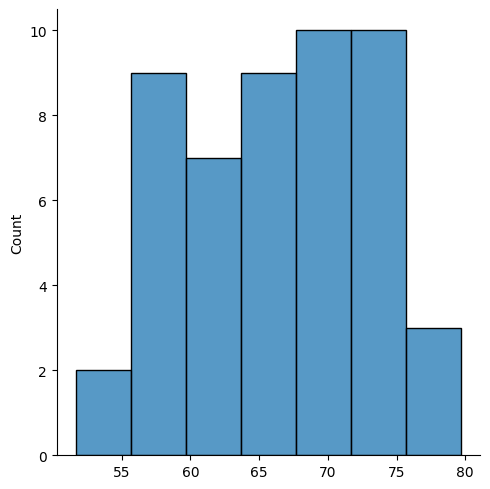

In [ ]:
sb.displot(np.array(mc_results))

In [ ]:
import numpy as np

## Class Exercise

The numpy function for correlation coefficients is `corrcoef`. Can we do a basic sensitivity analysis on the Monte Carlo parameters? See if you can capture the matrix values during each iteration, and then calculate the correlation coefficients between this matrix values and the LCIA scores.

# Correlating exchanges

If we sample each exchange independently, we lose some of the logic of our product system. In our example system, the $CO_{2}$ should be tied directly to the natural gas consumption, but it isn't:

In [ ]:
params = []

for _ in range(100):
    next(lca)
    params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

<Axes: xlabel='ng', ylabel='co2'>

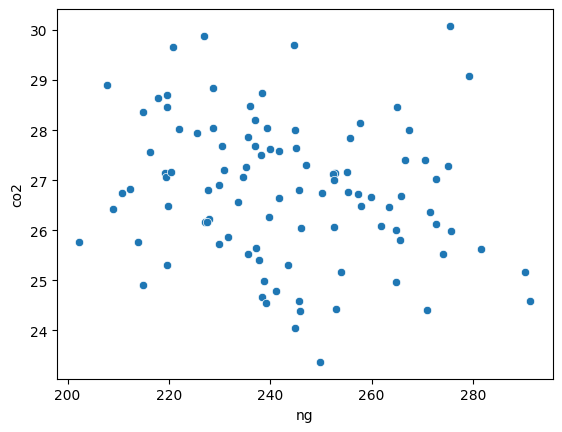

In [ ]:
sb.scatterplot(data=pd.DataFrame(params), x='ng', y='co2')

We fix this by drawing correlated samples ahead of time - this is the idea behind the `presamples` package, whose functionality is now integrated directly into Brightway. We will make up a model to illustrate how this would work; we can assume that (again, totally made up) 80% of the natural gas goes to energy, the ratio stays the same, but with a little bit of noise.

In [ ]:
ng_samples = np.random.triangular(200, 237, 300, size=100)
co2_samples = 26.6 / 237 * ng_samples * np.random.normal(loc=1, scale=0.025, size=100)

We can now add another datapackage which will overwrite our previous values (but only where we tell it to). Note that we are now creating `arrays`, not `vectors`.

We need to tell the datapackage that these two resources are correlated - otherwise there would be two RNGs used to samples them independently again. We can do this by either setting `sequential=True` (in which case they would start with column 0, then column 1, etc.), or by using the same RNG seed for both resources.

In [ ]:
dp_correlated = bwp.create_datapackage(seed=42)

In [ ]:
dp_correlated.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(101, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=ng_samples.reshape((1, -1)),
    flip_array=np.array([True]) ,
)
dp_correlated.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=np.array([(201, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=co2_samples.reshape((1, -1)),
)

And now the use of our correlated samples reflects reality a lot better. Note that we justs add the new datapackage after the original one, and set `use_arrays=True`:

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic, dp_correlated],
    use_distributions=True,
    use_arrays=True,
)
lca.lci()
lca.lcia()

corr_params = []

for _ in range(100):
    next(lca)
    corr_params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

<Axes: xlabel='ng', ylabel='co2'>

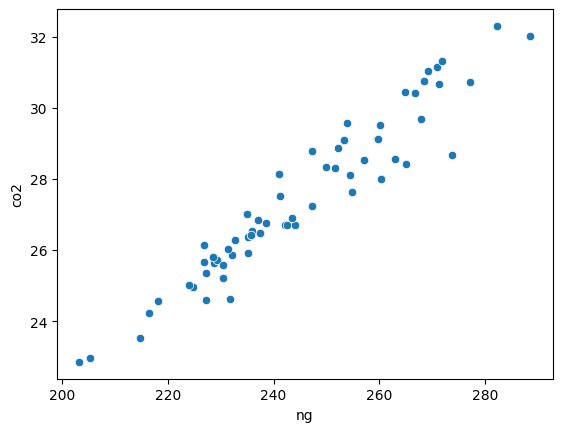

In [ ]:
sb.scatterplot(data=pd.DataFrame(corr_params), x='ng', y='co2')

## Exercise

Do the same for your steel bike - correlate iron ore resource consumption to mining.

# Using arrays for scenarios

In addition to correlated samples, we can use arrays for scenarios. Let's imagine two different possibilities: a lightweight bike with 1.5 kilograms of carbon fibre, and a technology platform that allows for efficient bike sharing making each bike functionally equivalent to two bikes (I know, I find this silly as well). If we treat these as separate possibilities, we have four scenarios in total.

For this to work, we will need to create **two** new arrays, one for each choice, and then tell the software to do combinatorial sampling:

In [ ]:
dp_scenarios = bwp.create_datapackage(combinatorial=True)

In [ ]:
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(102, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(2.5, 1.5)]),
    flip_array=np.array([True]),
    name='cf scenario'
)
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(103, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(1, 2)]),
    name='double bike'
)

In [ ]:
scenario_mapping = {
    (0, 0): "Original",
    (0, 1): "Each bike counts double",
    (1, 0): "Lightweight",
    (1, 1): "Lightweight & each bike counts double",
}

In [ ]:
 #run LCA calculations again with method
 lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, dp_scenarios],
    use_arrays=True,
)
lca.lci()
lca.lcia()



print(lca.inventory)

print(lca.score)


In [ ]:
print(lca.characterized_inventory)
sum(lca.characterized_inventory)
# the point with score is that what CM calls a method is an "impact category"...
# so he then assumes (correctly) everything is summed up

In [ ]:
resource_group = next(grp for grp in lca.technosphere_mm.groups if grp.label == 'double bike').indexer.indexer

In [ ]:
print(lca.score, scenario_mapping[resource_group.index])

for scenario_result in lca:
    print(lca.score, scenario_mapping[resource_group.index])

66.5 Original
33.25 Each bike counts double
39.900000000000006 Lightweight
19.950000000000003 Lightweight & each bike counts double
